# Citi Bike - Demand Forecasting with Advanced Clustering

**Project Overview:** Multi-level demand forecasting using behavioral clustering and ensemble machine learning models

**Key Features:**
- COVID-19 data filtering (June 2022 onwards for clean patterns)
- K-Means clustering for station behavior profiling (8 clusters)
- Three-tier prediction: System-wide → Cluster-level → Station-specific
- Multiple ML& models: Random Forest, XGBoost, LSTM
- Cluster-specific models for improved accuracy

---

Dataset: [Citi Bike](https://citibikenyc.com/system-data) - 2021-02-01 to 2025-09-30

## 1. Import Libraries

In [ ]:
# Data Processing
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

## 2. Data Loading

In [40]:
# Get all CSV files
dataset_path = Path("Dataset")
csv_files = sorted(dataset_path.glob("JC-*.csv"))
csv_files = [f for f in csv_files if 'merged' not in f.name.lower()]

# Load all files
all_data = []
for file in csv_files:
    df = pd.read_csv(file, low_memory=False)
    all_data.append(df)

# Merge all dataframes
bike = pd.concat(all_data, ignore_index=True)
bike['started_at'] = pd.to_datetime(bike['started_at'], format='ISO8601')
bike['ended_at'] = pd.to_datetime(bike['ended_at'], format='ISO8601')

print(f"Loaded {len(bike):,} trips from {bike['started_at'].min().date()} to {bike['started_at'].max().date()}")

Loaded 4,679,709 trips from 2021-02-01 to 2025-09-30


## 3. Data Preprocessing

### 3.1. Data Quality & Cleaning

In [41]:
print("DATA QUALITY CHECKS\n")

# 1. Check for missing values
print("1. Missing Values:")
missing_summary = bike.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]
if len(missing_summary) > 0:
    print(missing_summary)
    print(f"\nTotal rows with missing values: {bike.isnull().any(axis=1).sum():,}")
else:
    print("   No missing values found")

# 2. Remove rows with missing critical columns
critical_cols = ['started_at', 'ended_at', 'start_station_name', 'end_station_name']
bike_before = len(bike)
bike = bike.dropna(subset=critical_cols)
if bike_before - len(bike) > 0:
    print(f"   Removed {bike_before - len(bike):,} rows with missing critical data")

# 3. Check for duplicate rows
print("\n2. Duplicate Rows:")
duplicates = bike.duplicated().sum()
if duplicates > 0:
    print(f"   Found {duplicates:,} duplicate rows")
    bike = bike.drop_duplicates()
    print(f"   Removed duplicates - {len(bike):,} unique trips remain")
else:
    print(f"   No duplicates found")

# 4. Calculate trip duration and remove invalid trips
print("\n3. Trip Duration Validation:")
bike['trip_duration_min'] = (bike['ended_at'] - bike['started_at']).dt.total_seconds() / 60
print(f"   Original trips: {len(bike):,}")
print(f"   Duration range: {bike['trip_duration_min'].min():.1f} to {bike['trip_duration_min'].max():.1f} min")

# Keep only valid trips (1-180 minutes)
bike_clean = bike[(bike['trip_duration_min'] >= 1) & (bike['trip_duration_min'] <= 180)].copy()
removed = len(bike) - len(bike_clean)
print(f"   Removed {removed:,} invalid trips (duration <1 min or >180 min)")
print(f"   Retained {len(bike_clean):,} valid trips ({len(bike_clean)/len(bike)*100:.1f}%)")
# 5. Remove COVID-contaminated data
covid_cutoff = '2022-06-01'
bike_clean_before = len(bike_clean)
bike_clean = bike_clean[bike_clean['started_at'] >= covid_cutoff].copy()

print(f"\nFINAL CLEAN DATASET: {len(bike_clean):,} trips ({len(bike_clean)/bike_before*100:.1f}% of original)")

DATA QUALITY CHECKS

1. Missing Values:
tripduration               4342907
starttime                  4342907
stoptime                   4342907
start station id           4342907
start station name         4342907
start station latitude     4342907
start station longitude    4342907
end station id             4342907
end station name           4342907
end station latitude       4342907
end station longitude      4342907
bikeid                     4342907
usertype                   4342907
birth year                 4342907
gender                     4342907
ride_id                     336802
rideable_type               336802
started_at                  336802
ended_at                    336802
start_station_name          337003
start_station_id            337003
end_station_name            352074
end_station_id              352865
start_lat                   336803
start_lng                   336803
end_lat                     344060
end_lng                     344060
member_casual  


## 4. Exploratory Data Analysis (EDA)

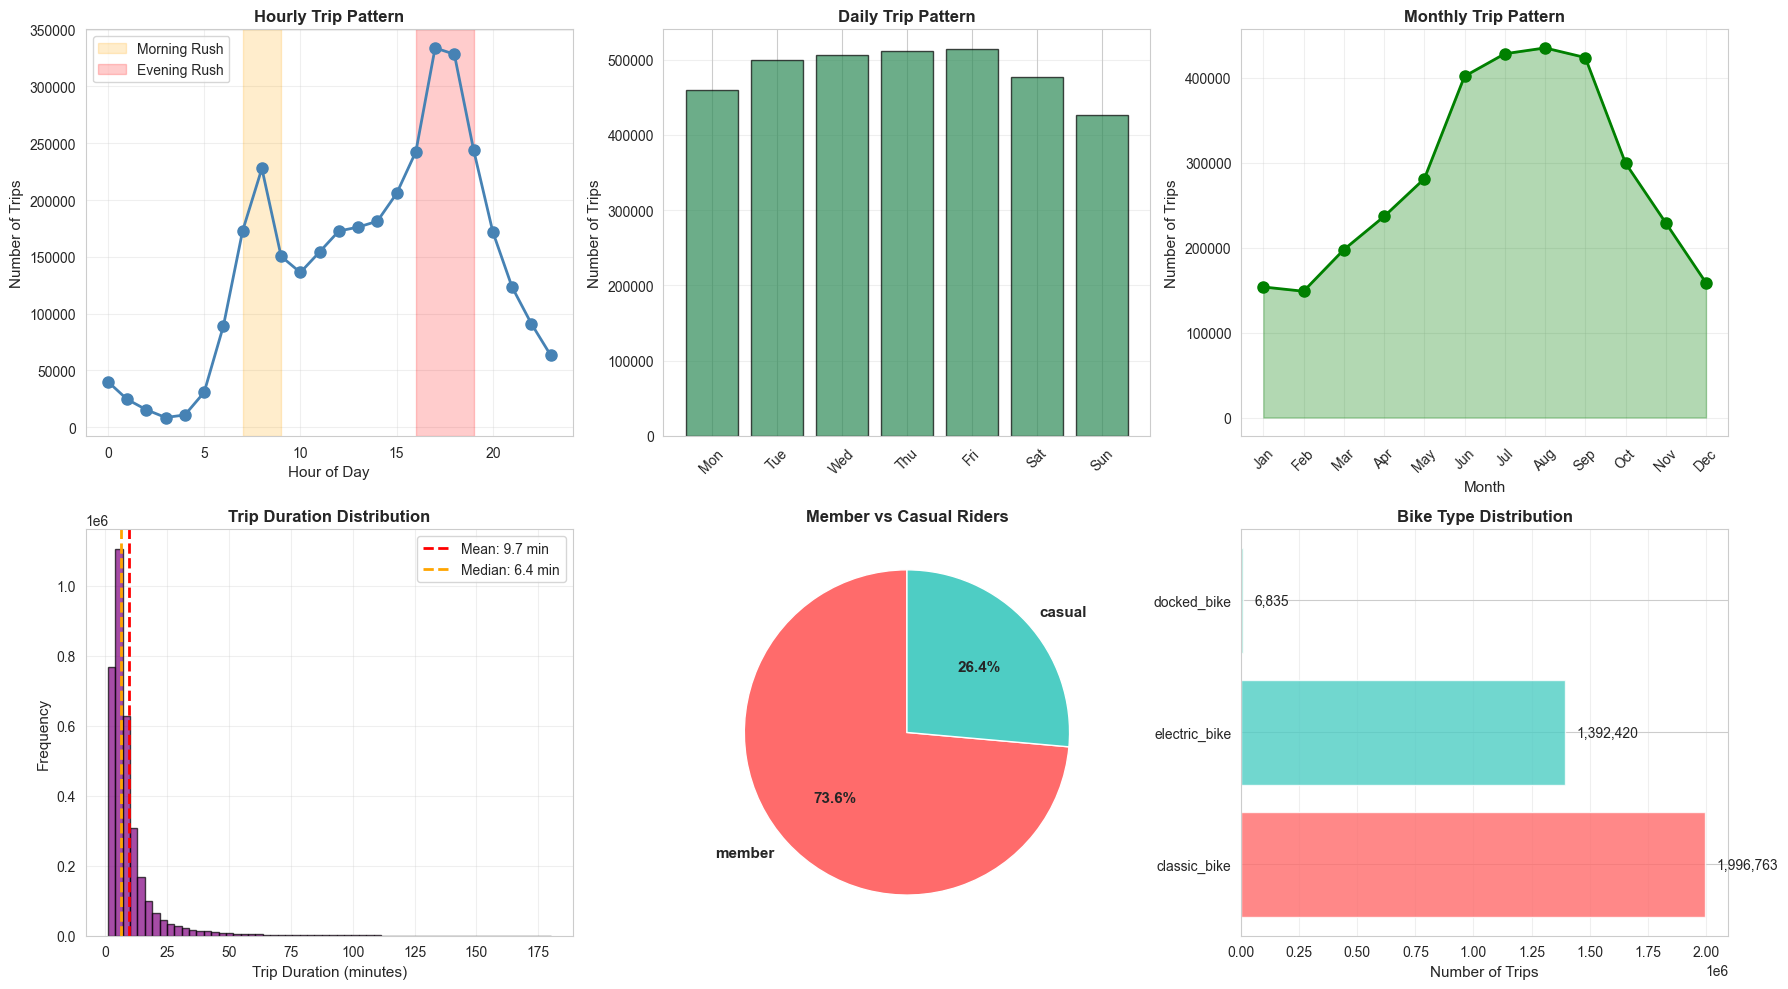


Key Insights:
Peak hours: [17, 18, 19] (Rush hours: 7-9 AM, 4-7 PM)
Busiest day: Friday (514,390 trips)
Busiest month: Aug (435,371 trips)
Average trip duration: 9.7 minutes
Median trip duration: 6.4 minutes
Member vs Casual: 2,499,147 vs 896,871


In [42]:
# Extract temporal features
bike_clean['hour'] = bike_clean['started_at'].dt.hour
bike_clean['day_of_week'] = bike_clean['started_at'].dt.dayofweek
bike_clean['month'] = bike_clean['started_at'].dt.month
bike_clean['day_name'] = bike_clean['started_at'].dt.day_name()

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Hourly pattern
hourly = bike_clean.groupby('hour').size()
axes[0, 0].plot(hourly.index, hourly.values, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0, 0].set_xlabel('Hour of Day', fontsize=11)
axes[0, 0].set_ylabel('Number of Trips', fontsize=11)
axes[0, 0].set_title('Hourly Trip Pattern', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvspan(7, 9, alpha=0.2, color='orange', label='Morning Rush')
axes[0, 0].axvspan(16, 19, alpha=0.2, color='red', label='Evening Rush')
axes[0, 0].legend()

# 2. Daily pattern
daily = bike_clean['day_name'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axes[0, 1].bar(range(7), daily.values, color='seagreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
axes[0, 1].set_ylabel('Number of Trips', fontsize=11)
axes[0, 1].set_title('Daily Trip Pattern', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Monthly pattern
monthly = bike_clean.groupby('month').size()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 2].plot(monthly.index, monthly.values, marker='o', linewidth=2, markersize=8, color='green')
axes[0, 2].set_xlabel('Month', fontsize=11)
axes[0, 2].set_ylabel('Number of Trips', fontsize=11)
axes[0, 2].set_title('Monthly Trip Pattern', fontsize=12, fontweight='bold')
axes[0, 2].set_xticks(range(1, 13))
axes[0, 2].set_xticklabels(month_names, rotation=45)
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].fill_between(monthly.index, monthly.values, alpha=0.3, color='green')

# 4. Trip duration distribution
axes[1, 0].hist(bike_clean['trip_duration_min'], bins=60, color='purple', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Trip Duration (minutes)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Trip Duration Distribution', fontsize=12, fontweight='bold')
axes[1, 0].axvline(bike_clean['trip_duration_min'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {bike_clean["trip_duration_min"].mean():.1f} min')
axes[1, 0].axvline(bike_clean['trip_duration_min'].median(), color='orange', linestyle='--', linewidth=2,
                   label=f'Median: {bike_clean["trip_duration_min"].median():.1f} min')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Member vs Casual
member_data = bike_clean['member_casual'].value_counts()
colors = ['#FF6B6B', '#4ECDC4']
axes[1, 1].pie(member_data.values, labels=member_data.index, autopct='%1.1f%%', 
               colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1, 1].set_title('Member vs Casual Riders', fontsize=12, fontweight='bold')

# 6. Bike type distribution
bike_types = bike_clean['rideable_type'].value_counts()
axes[1, 2].barh(bike_types.index, bike_types.values, color=['#FF6B6B', '#4ECDC4', '#95E1D3'], alpha=0.8)
axes[1, 2].set_xlabel('Number of Trips', fontsize=11)
axes[1, 2].set_title('Bike Type Distribution', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(bike_types.values):
    axes[1, 2].text(v + 50000, i, f'{v:,}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"Peak hours: {hourly.nlargest(3).index.tolist()} (Rush hours: 7-9 AM, 4-7 PM)")
print(f"Busiest day: {daily.idxmax()} ({daily.max():,} trips)")
print(f"Busiest month: {month_names[monthly.idxmax()-1]} ({monthly.max():,} trips)")
print(f"Average trip duration: {bike_clean['trip_duration_min'].mean():.1f} minutes")
print(f"Median trip duration: {bike_clean['trip_duration_min'].median():.1f} minutes")
print(f"Member vs Casual: {member_data['member']:,} vs {member_data['casual']:,}")

## 5. Feature Engineering

In [43]:
# Aggregate to hourly level WITH STATION INFORMATION
bike_clean['hour_floor'] = bike_clean['started_at'].dt.floor('H')

# Create station-wise hourly demand
station_hourly_demand = bike_clean.groupby(['hour_floor', 'start_station_name']).size().reset_index(name='trip_count')

# Also create system-wide hourly demand for reference
hourly_demand = bike_clean.groupby('hour_floor').size().reset_index(name='trip_count')

print(f"Created {len(station_hourly_demand):,} station-hour records")
print(f"Tracking {bike_clean['start_station_name'].nunique()} unique stations")
print(f"Date range: {station_hourly_demand['hour_floor'].min()} to {station_hourly_demand['hour_floor'].max()}")

# Extract temporal features
hourly_demand['month'] = hourly_demand['hour_floor'].dt.month
hourly_demand['day_of_week'] = hourly_demand['hour_floor'].dt.dayofweek
hourly_demand['hour_of_day'] = hourly_demand['hour_floor'].dt.hour
hourly_demand['day_of_month'] = hourly_demand['hour_floor'].dt.day
hourly_demand['week_of_year'] = hourly_demand['hour_floor'].dt.isocalendar().week
hourly_demand['is_weekend'] = (hourly_demand['day_of_week'] >= 5).astype(int)

# Cyclical encoding
hourly_demand['hour_sin'] = np.sin(2 * np.pi * hourly_demand['hour_of_day'] / 24)
hourly_demand['hour_cos'] = np.cos(2 * np.pi * hourly_demand['hour_of_day'] / 24)
hourly_demand['dow_sin'] = np.sin(2 * np.pi * hourly_demand['day_of_week'] / 7)
hourly_demand['dow_cos'] = np.cos(2 * np.pi * hourly_demand['day_of_week'] / 7)
hourly_demand['month_sin'] = np.sin(2 * np.pi * hourly_demand['month'] / 12)
hourly_demand['month_cos'] = np.cos(2 * np.pi * hourly_demand['month'] / 12)

# Lag features
hourly_demand = hourly_demand.sort_values('hour_floor').reset_index(drop=True)
hourly_demand['lag_1h'] = hourly_demand['trip_count'].shift(1)
hourly_demand['lag_24h'] = hourly_demand['trip_count'].shift(24)
hourly_demand['lag_168h'] = hourly_demand['trip_count'].shift(168)

# Rolling statistics
hourly_demand['rolling_mean_6h'] = hourly_demand['trip_count'].rolling(window=6, min_periods=1).mean()
hourly_demand['rolling_mean_24h'] = hourly_demand['trip_count'].rolling(window=24, min_periods=1).mean()
hourly_demand['rolling_std_24h'] = hourly_demand['trip_count'].rolling(window=24, min_periods=1).std()
hourly_demand['rolling_max_24h'] = hourly_demand['trip_count'].rolling(window=24, min_periods=1).max()
hourly_demand['rolling_min_24h'] = hourly_demand['trip_count'].rolling(window=24, min_periods=1).min()

# Remove NaN from lag features
hourly_demand_clean = hourly_demand.dropna().reset_index(drop=True)

print(f"\nBasic features engineered!")
print(f"Final dataset: {len(hourly_demand_clean):,} hours")

Created 1,219,590 station-hour records
Tracking 448 unique stations
Date range: 2022-06-01 00:00:00 to 2025-09-30 23:00:00

Basic features engineered!
Final dataset: 28,946 hours


In [44]:
# Outlier Detection & Handling
print("\n5. Outlier Detection (Trip Count):")
Q1 = hourly_demand['trip_count'].quantile(0.25)
Q3 = hourly_demand['trip_count'].quantile(0.75)
IQR = Q3 - Q1

outliers = hourly_demand[(hourly_demand['trip_count'] < Q1 - 1.5*IQR) | 
                         (hourly_demand['trip_count'] > Q3 + 1.5*IQR)]
print(f"   Q1: {Q1:.0f}, Q3: {Q3:.0f}, IQR: {IQR:.0f}")
print(f"   Outliers detected: {len(outliers):,} hours ({len(outliers)/len(hourly_demand)*100:.2f}%)")
print(f"   Outlier range: {outliers['trip_count'].min():.0f} to {outliers['trip_count'].max():.0f} trips")
print(f"   Keeping outliers (they represent real peak demand patterns)")

# Fill temporal gaps (ensure all hours exist)
print("\n6. Temporal Gap Filling:")
before_gap_fill = len(hourly_demand)
hourly_demand = hourly_demand.set_index('hour_floor').resample('H').asfreq()
hourly_demand['trip_count'] = hourly_demand['trip_count'].fillna(0)
hourly_demand = hourly_demand.reset_index()
gaps_filled = len(hourly_demand) - before_gap_fill
print(f"   Filled {gaps_filled:,} missing hours with 0 trips")
print(f"   Complete hourly series: {len(hourly_demand):,} hours")


5. Outlier Detection (Trip Count):
   Q1: 31, Q3: 172, IQR: 141
   Outliers detected: 561 hours (1.93%)
   Outlier range: 384 to 594 trips
   Keeping outliers (they represent real peak demand patterns)

6. Temporal Gap Filling:
   Filled 118 missing hours with 0 trips
   Complete hourly series: 29,232 hours


In [45]:
# Holidays
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2021-01-01', end='2027-01-01').date

# Extra Citi Bike special days
extra_holidays = [
    '2021-12-31', '2022-12-31', '2023-12-31', '2024-12-31', '2025-12-31', '2026-12-31',
    '2021-11-07', '2022-11-06', '2023-11-05', '2024-11-03', '2025-11-02', '2026-11-01',
]
holidays = pd.Index(holidays).union(pd.to_datetime(extra_holidays).date)

hourly_demand_clean['date'] = hourly_demand_clean['hour_floor'].dt.date
hourly_demand_clean['is_holiday'] = hourly_demand_clean['date'].isin(holidays).astype(int)
hourly_demand_clean['is_nye'] = ((hourly_demand_clean['hour_floor'].dt.month == 12) & 
                                  (hourly_demand_clean['hour_floor'].dt.day == 31)).astype(int)
hourly_demand_clean.drop('date', axis=1, inplace=True)

# NOTE: COVID period data (Feb 2021 - Jun 2022) is now removed from the dataset
# No need for covid_period feature since we only train on post-June 2022 data

# Rush Hours - When people commute to/from work
# Morning rush: 7 AM - 9 AM (people going to work)
# Evening rush: 4 PM - 7 PM (people going home)
# These hours typically have higher bike demand
hourly_demand_clean['is_morning_rush'] = ((hourly_demand_clean['hour_of_day'] >= 7) & 
                                           (hourly_demand_clean['hour_of_day'] <= 9)).astype(int)
hourly_demand_clean['is_evening_rush'] = ((hourly_demand_clean['hour_of_day'] >= 16) & 
                                           (hourly_demand_clean['hour_of_day'] <= 19)).astype(int)




7. Feature Correlation Analysis:

Top 10 Positive Correlations:
   lag_1h                   : +0.866
   lag_24h                  : +0.828
   lag_168h                 : +0.805
   rolling_mean_6h          : +0.668
   is_evening_rush          : +0.538
   hour_of_day              : +0.434
   rolling_mean_24h         : +0.366
   rolling_std_24h          : +0.358
   rolling_max_24h          : +0.352
   is_morning_rush          : +0.131

Top 5 Negative Correlations:
   is_weekend               : -0.055
   month_sin                : -0.207
   month_cos                : -0.209
   hour_cos                 : -0.441
   hour_sin                 : -0.460


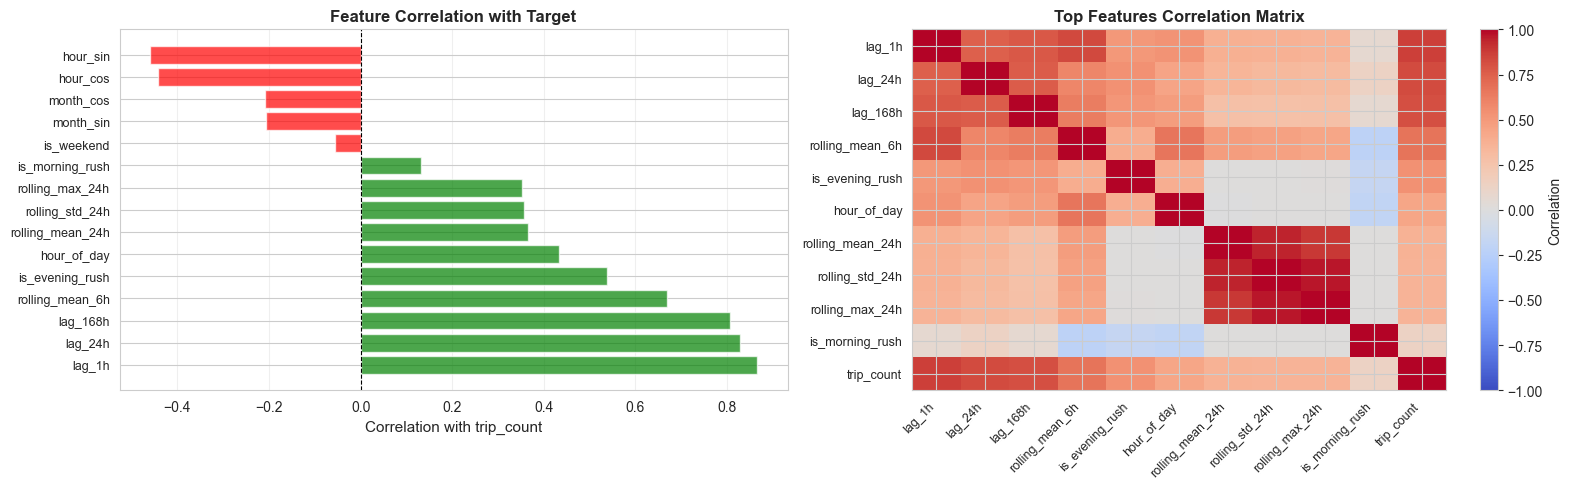


Validation: Strong predictors identified (|corr| > 0.3): 11 features


In [46]:
# Feature Correlation Analysis
print("\n7. Feature Correlation Analysis:")

# Select all features and target
feature_cols_for_corr = [col for col in hourly_demand_clean.columns 
                         if col not in ['hour_floor', 'trip_count']]

# Calculate correlations with target
correlations = hourly_demand_clean[feature_cols_for_corr + ['trip_count']].corr()['trip_count'].drop('trip_count').sort_values(ascending=False)

print(f"\nTop 10 Positive Correlations:")
for feat, corr_val in correlations.head(10).items():
    print(f"   {feat:25s}: {corr_val:+.3f}")

print(f"\nTop 5 Negative Correlations:")
for feat, corr_val in correlations.tail(5).items():
    print(f"   {feat:25s}: {corr_val:+.3f}")

# Visualization: Top 15 features
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar plot of correlations
top_features = pd.concat([correlations.head(10), correlations.tail(5)])
colors_corr = ['green' if x > 0 else 'red' for x in top_features.values]
axes[0].barh(range(len(top_features)), top_features.values, color=colors_corr, alpha=0.7)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features.index, fontsize=9)
axes[0].set_xlabel('Correlation with trip_count', fontsize=11)
axes[0].set_title('Feature Correlation with Target', fontsize=12, fontweight='bold')
axes[0].axvline(0, color='black', linewidth=0.8, linestyle='--')
axes[0].grid(True, alpha=0.3, axis='x')

# Heatmap of top features
top_10_features = correlations.head(10).index.tolist()
corr_matrix = hourly_demand_clean[top_10_features + ['trip_count']].corr()
im = axes[1].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[1].set_xticks(range(len(corr_matrix.columns)))
axes[1].set_yticks(range(len(corr_matrix.columns)))
axes[1].set_xticklabels(corr_matrix.columns, rotation=45, ha='right', fontsize=9)
axes[1].set_yticklabels(corr_matrix.columns, fontsize=9)
axes[1].set_title('Top Features Correlation Matrix', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=axes[1], label='Correlation')

plt.tight_layout()
plt.show()

print(f"\nValidation: Strong predictors identified (|corr| > 0.3): {(abs(correlations) > 0.3).sum()} features")

## 6.Train-Test Split

In [47]:
# Define features 
feature_cols = ['month', 'day_of_week', 'hour_of_day', 'day_of_month', 'week_of_year', 
                'is_weekend', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 
                'month_sin', 'month_cos', 'lag_1h', 'lag_24h', 'lag_168h',
                'rolling_mean_6h', 'rolling_mean_24h', 'rolling_std_24h',
                'rolling_max_24h', 'rolling_min_24h',
                'is_holiday', 'is_nye',
                'is_morning_rush', 'is_evening_rush']

X = hourly_demand_clean[feature_cols]
y = hourly_demand_clean['trip_count']

# Time-based split
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training data: {len(X_train):,} hours ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing data: {len(X_test):,} hours ({len(X_test)/len(X)*100:.1f}%)")

Training data: 23,156 hours (80.0%)
Testing data: 5,790 hours (20.0%)


In [48]:
# Baseline Models for Comparison
print("BASELINE MODELS (for comparison with ML models)\n")

# Baseline 1: Lag-1 (previous hour)
baseline_lag1 = hourly_demand_clean.copy()
baseline_lag1['pred'] = baseline_lag1['lag_1h']
baseline_lag1_mae = mean_absolute_error(y_test, baseline_lag1.loc[y_test.index, 'pred'])

# Baseline 2: Same hour yesterday (lag-24)
baseline_lag24_mae = mean_absolute_error(y_test, X_test['lag_24h'])

# Baseline 3: Mean of last 7 days at same hour
baseline_rolling_mae = mean_absolute_error(y_test, X_test['rolling_mean_24h'])

print(f"Baseline Performance:")
print(f"   Lag-1 (previous hour):        MAE = {baseline_lag1_mae:.2f} trips")
print(f"   Lag-24 (same hour yesterday): MAE = {baseline_lag24_mae:.2f} trips")
print(f"   Rolling mean (7-day avg):     MAE = {baseline_rolling_mae:.2f} trips")

BASELINE MODELS (for comparison with ML models)

Baseline Performance:
   Lag-1 (previous hour):        MAE = 37.88 trips
   Lag-24 (same hour yesterday): MAE = 39.77 trips
   Rolling mean (7-day avg):     MAE = 75.90 trips


## 7. Machine Learning Models

### 7.1. Random Forest Model

In [49]:
# Train Random Forest
rf_fast = RandomForestRegressor(
    n_estimators=300,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

rf_fast.fit(X_train, y_train)
y_pred_train_rf = rf_fast.predict(X_train)
y_pred_test_rf = rf_fast.predict(X_test)

rf_train_mae = mean_absolute_error(y_train, y_pred_train_rf)
rf_test_mae = mean_absolute_error(y_test, y_pred_test_rf)
rf_train_r2 = r2_score(y_train, y_pred_train_rf)
rf_test_r2 = r2_score(y_test, y_pred_test_rf)

print(f"Random Forest - Train MAE: {rf_train_mae:.2f}, Test MAE: {rf_test_mae:.2f}, Test R²: {rf_test_r2:.4f}")

Random Forest - Train MAE: 6.92, Test MAE: 13.90, Test R²: 0.9564


### 7.2. XGBoost Model

In [50]:
import xgboost as xgb

# Train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    eval_metric='mae'
)

xgb_model.fit(X_train, y_train)

# Predictions
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

# Evaluate
xgb_train_mae = mean_absolute_error(y_train, y_pred_train_xgb)
xgb_test_mae = mean_absolute_error(y_test, y_pred_test_xgb)
xgb_train_r2 = r2_score(y_train, y_pred_train_xgb)
xgb_test_r2 = r2_score(y_test, y_pred_test_xgb)

print(f"XGBoost - Train MAE: {xgb_train_mae:.2f}, Test MAE: {xgb_test_mae:.2f}, Test R^2: {xgb_test_r2:.4f}")

# Feature importance
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(xgb_importance.head(10).to_string(index=False))

XGBoost - Train MAE: 5.17, Test MAE: 12.64, Test R^2: 0.9635

Top 10 Most Important Features:
        feature  importance
         lag_1h    0.352429
       hour_cos    0.126871
        lag_24h    0.102472
is_evening_rush    0.060439
is_morning_rush    0.058273
       hour_sin    0.054461
       lag_168h    0.050123
    hour_of_day    0.046268
     is_weekend    0.029813
rolling_max_24h    0.026402


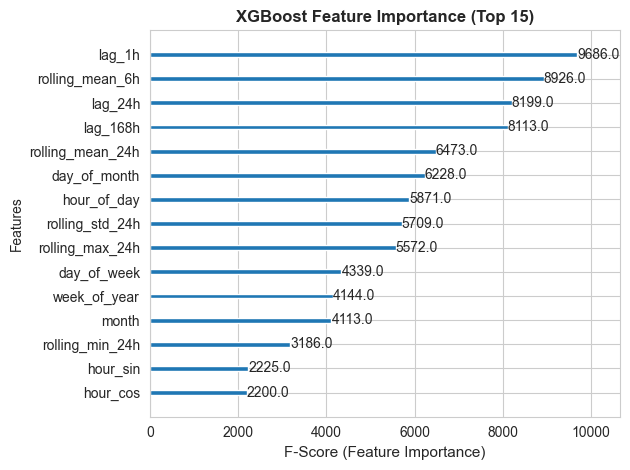

In [51]:
# Feature Importance Visualization
xgb.plot_importance(xgb_model, max_num_features=15, importance_type='weight')
plt.title('XGBoost Feature Importance (Top 15)', fontweight='bold')
plt.xlabel('F-Score (Feature Importance)', fontsize=11)
plt.tight_layout()
plt.show()

### 7.3. ML Models Evaluation and Visualization

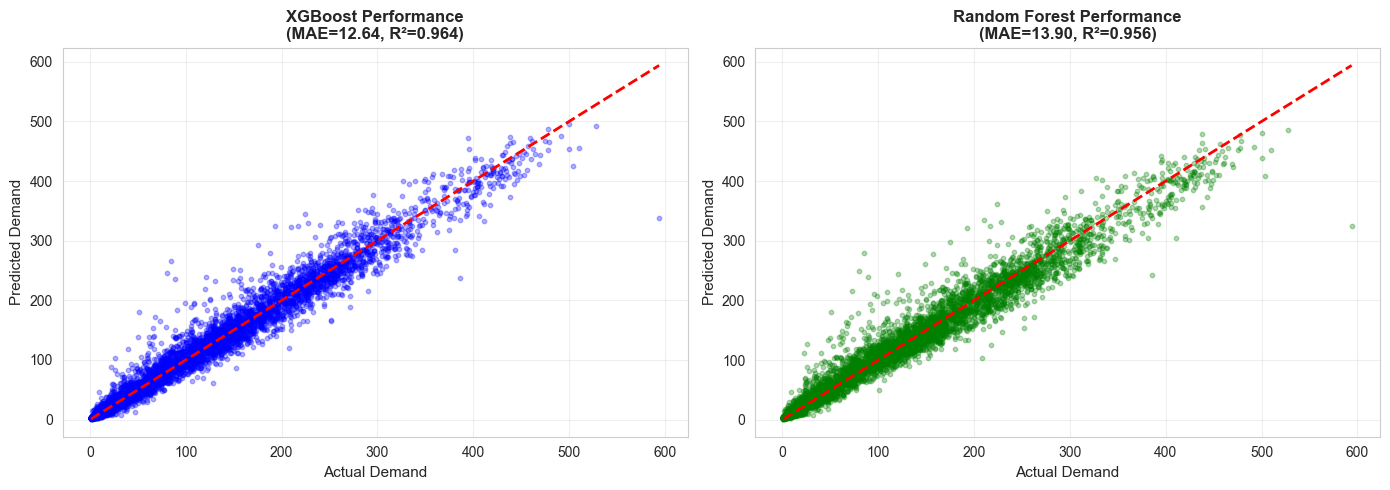


Machine Learning Models Summary:
Model           Train MAE    Test MAE     Test R²   
XGBoost         5.17         12.64        0.9635    
Random Forest   6.92         13.90        0.9564    


In [52]:
# Visualize ML Models Performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# XGBoost
axes[0].scatter(y_test, y_pred_test_xgb, alpha=0.3, s=10, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_title(f'XGBoost Performance\n(MAE={xgb_test_mae:.2f}, R²={xgb_test_r2:.3f})', fontweight='bold')
axes[0].set_xlabel('Actual Demand', fontsize=11)
axes[0].set_ylabel('Predicted Demand', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Random Forest
axes[1].scatter(y_test, y_pred_test_rf, alpha=0.3, s=10, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_title(f'Random Forest Performance\n(MAE={rf_test_mae:.2f}, R²={rf_test_r2:.3f})', fontweight='bold')
axes[1].set_xlabel('Actual Demand', fontsize=11)
axes[1].set_ylabel('Predicted Demand', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nMachine Learning Models Summary:")
print(f"{'Model':<15} {'Train MAE':<12} {'Test MAE':<12} {'Test R²':<10}")
print(f"{'XGBoost':<15} {xgb_train_mae:<12.2f} {xgb_test_mae:<12.2f} {xgb_test_r2:<10.4f}")
print(f"{'Random Forest':<15} {rf_train_mae:<12.2f} {rf_test_mae:<12.2f} {rf_test_r2:<10.4f}")

In [53]:
# Cross-Validation with TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

print("\nPerforming Time Series Cross-Validation...")
tscv = TimeSeriesSplit(n_splits=5)
cv_scores_xgb = []
cv_scores_rf = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    # XGBoost CV
    xgb_cv = xgb.XGBRegressor(n_estimators=500, max_depth=8, learning_rate=0.05, 
                              subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
    xgb_cv.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred_xgb = xgb_cv.predict(X.iloc[test_idx])
    r2_xgb = r2_score(y.iloc[test_idx], pred_xgb)
    cv_scores_xgb.append(r2_xgb)
    
    # Random Forest CV
    rf_cv = RandomForestRegressor(n_estimators=300, max_depth=25, min_samples_split=5,
                                  min_samples_leaf=2, max_features='sqrt', random_state=42, n_jobs=-1)
    rf_cv.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred_rf = rf_cv.predict(X.iloc[test_idx])
    r2_rf = r2_score(y.iloc[test_idx], pred_rf)
    cv_scores_rf.append(r2_rf)
    
    print(f"Fold {fold}: XGBoost R²={r2_xgb:.4f}, Random Forest R²={r2_rf:.4f}")

print(f"\nCross-Validation Results:")
print(f"XGBoost:      R² = {np.mean(cv_scores_xgb):.4f} ± {np.std(cv_scores_xgb):.4f}")
print(f"Random Forest: R² = {np.mean(cv_scores_rf):.4f} ± {np.std(cv_scores_rf):.4f}")
print(f"\nThis validates the single split results - models are stable across folds.")


Performing Time Series Cross-Validation...
Fold 1: XGBoost R²=0.9426, Random Forest R²=0.9270
Fold 2: XGBoost R²=0.9629, Random Forest R²=0.9518
Fold 3: XGBoost R²=0.9618, Random Forest R²=0.9502
Fold 4: XGBoost R²=0.9673, Random Forest R²=0.9594
Fold 5: XGBoost R²=0.9617, Random Forest R²=0.9552

Cross-Validation Results:
XGBoost:      R² = 0.9593 ± 0.0086
Random Forest: R² = 0.9487 ± 0.0113

This validates the single split results - models are stable across folds.


## 8. Deep Learning Model (LSTM)

In [54]:
# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Create sequences
time_steps = 12

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Build and train LSTM model
lstm_model = Sequential([
    LSTM(50, input_shape=(time_steps, len(feature_cols))),
    Dense(20, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='huber')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=15, batch_size=128, verbose=1,
               callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

# Evaluate
pred_train = lstm_model.predict(X_train_lstm, verbose=0).flatten()
pred_train = scaler_y.inverse_transform(pred_train.reshape(-1,1)).flatten()
actual_train = scaler_y.inverse_transform(y_train_lstm.reshape(-1,1)).flatten()

pred_test = lstm_model.predict(X_test_lstm, verbose=0).flatten()
pred_test = scaler_y.inverse_transform(pred_test.reshape(-1,1)).flatten()
actual_test = scaler_y.inverse_transform(y_test_lstm.reshape(-1,1)).flatten()

lstm_train_mae = mean_absolute_error(actual_train, pred_train)
lstm_test_mae = mean_absolute_error(actual_test, pred_test)
lstm_train_r2 = r2_score(actual_train, pred_train)
lstm_test_r2 = r2_score(actual_test, pred_test)

print(f"\nLSTM - Train MAE: {lstm_train_mae:.2f}, Test MAE: {lstm_test_mae:.2f}, Test R²: {lstm_test_r2:.4f}")

Epoch 1/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1105
Epoch 2/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0444
Epoch 3/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0366
Epoch 4/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0333
Epoch 5/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0314
Epoch 6/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0300
Epoch 7/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0289
Epoch 8/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0280
Epoch 9/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0272
Epoch 10/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0265
Epoch 11/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0259
Epoch 12/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0254
Epoch 13/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0249
Epoch 14/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0244
Epoch 15/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s

### 8.1. LSTM Model Evaluation and Visualization

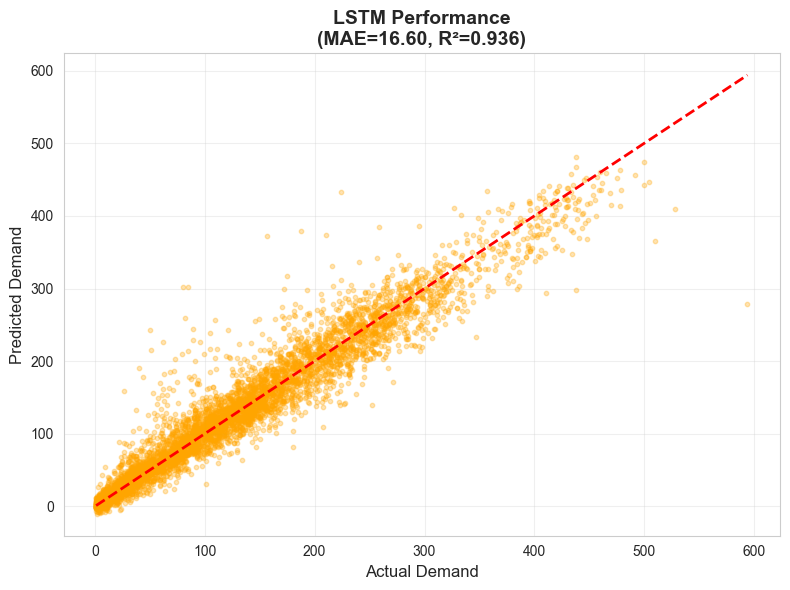


Deep Learning Model Summary:
Model           Train MAE    Test MAE     Test R²   
LSTM            14.63        16.60        0.9355    


In [55]:
# Visualize LSTM Performance
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(actual_test, pred_test, alpha=0.3, s=10, color='orange')
ax.plot([actual_test.min(), actual_test.max()], [actual_test.min(), actual_test.max()], 'r--', lw=2)
ax.set_title(f'LSTM Performance\n(MAE={lstm_test_mae:.2f}, R²={lstm_test_r2:.3f})', fontsize=14, fontweight='bold')
ax.set_xlabel('Actual Demand', fontsize=12)
ax.set_ylabel('Predicted Demand', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDeep Learning Model Summary:")
print(f"{'Model':<15} {'Train MAE':<12} {'Test MAE':<12} {'Test R²':<10}")
print(f"{'LSTM':<15} {lstm_train_mae:<12.2f} {lstm_test_mae:<12.2f} {lstm_test_r2:<10.4f}")

## 9. Model Comparison (ML vs DL)

In [56]:
comparison = pd.DataFrame({
    'Model': ['XGBoost', 'Random Forest', 'LSTM'],
    'Train MAE': [xgb_train_mae, rf_train_mae, lstm_train_mae],
    'Test MAE': [xgb_test_mae, rf_test_mae, lstm_test_mae],
    'Test R²': [xgb_test_r2, rf_test_r2, lstm_test_r2]
})

print("\nModel Comparison:")
print(comparison.to_string(index=False))

best_idx = comparison['Test MAE'].idxmin()
print(f"\nBest: {comparison.loc[best_idx, 'Model']} (MAE: {comparison.loc[best_idx, 'Test MAE']:.2f}, R²: {comparison.loc[best_idx, 'Test R²']:.4f})")



Model Comparison:
        Model  Train MAE  Test MAE  Test R²
      XGBoost   5.173143 12.637083 0.963525
Random Forest   6.923688 13.903591 0.956359
         LSTM  14.632718 16.602503 0.935524

Best: XGBoost (MAE: 12.64, R²: 0.9635)


In [57]:
# Model Improvement Over Baselines
print("\nIMPROVEMENT OVER BASELINES:\n")

# Calculate improvement percentages
xgb_improvement = ((baseline_lag24_mae - xgb_test_mae) / baseline_lag24_mae) * 100
rf_improvement = ((baseline_lag24_mae - rf_test_mae) / baseline_lag24_mae) * 100
lstm_improvement = ((baseline_lag24_mae - lstm_test_mae) / baseline_lag24_mae) * 100

print(f"XGBoost:      {xgb_improvement:.1f}% better than lag-24 baseline")
print(f"Random Forest: {rf_improvement:.1f}% better than lag-24 baseline")
print(f"LSTM:         {lstm_improvement:.1f}% better than lag-24 baseline")

print(f"\nXGBoost MAE: {xgb_test_mae:.2f} vs Baseline: {baseline_lag24_mae:.2f}")
print(f"Absolute error reduction: {baseline_lag24_mae - xgb_test_mae:.2f} trips per hour")


IMPROVEMENT OVER BASELINES:

XGBoost:      68.2% better than lag-24 baseline
Random Forest: 65.0% better than lag-24 baseline
LSTM:         58.2% better than lag-24 baseline

XGBoost MAE: 12.64 vs Baseline: 39.77
Absolute error reduction: 27.13 trips per hour


### currently the above models just predict the city level (complete) perfectly but fails to predict station level demand prediction

## Improvement to make prediction for Station Level

## 10. Station Clustering

### 10.1. Station Profiling & Clustering

Building advanced station profiles with behavioral features...

Step 1: Analyzing station characteristics...
Created profiles for 97 stations

Step 2: Clustering stations into behavioral groups...
Clustered into 8 behavioral groups

CLUSTER PROFILES:

Cluster 0: Morning Commuter Hub
   Stations: 9
   Total Trips: 577,882
   Morning Peak: 10.9%
   Evening Peak: 45.5%
   Weekend Usage: 24.1%
   Member Ratio: 76.4%
   Example 1: Grove St PATH
   Example 2: Hoboken Terminal - River St & Hudson Pl

Cluster 1: Evening Commuter Hub
   Stations: 27
   Total Trips: 919,618
   Morning Peak: 25.1%
   Evening Peak: 27.9%
   Weekend Usage: 25.1%
   Member Ratio: 72.2%
   Example 1: Hamilton Park
   Example 2: 8 St & Washington St

Cluster 2: Weekend Recreational
   Stations: 9
   Total Trips: 439,769
   Morning Peak: 17.9%
   Evening Peak: 33.7%
   Weekend Usage: 29.6%
   Member Ratio: 60.9%
   Example 1: South Waterfront Walkway - Sinatra Dr & 1 St
   Example 2: 11 St & Washington St

Cluster 3: B

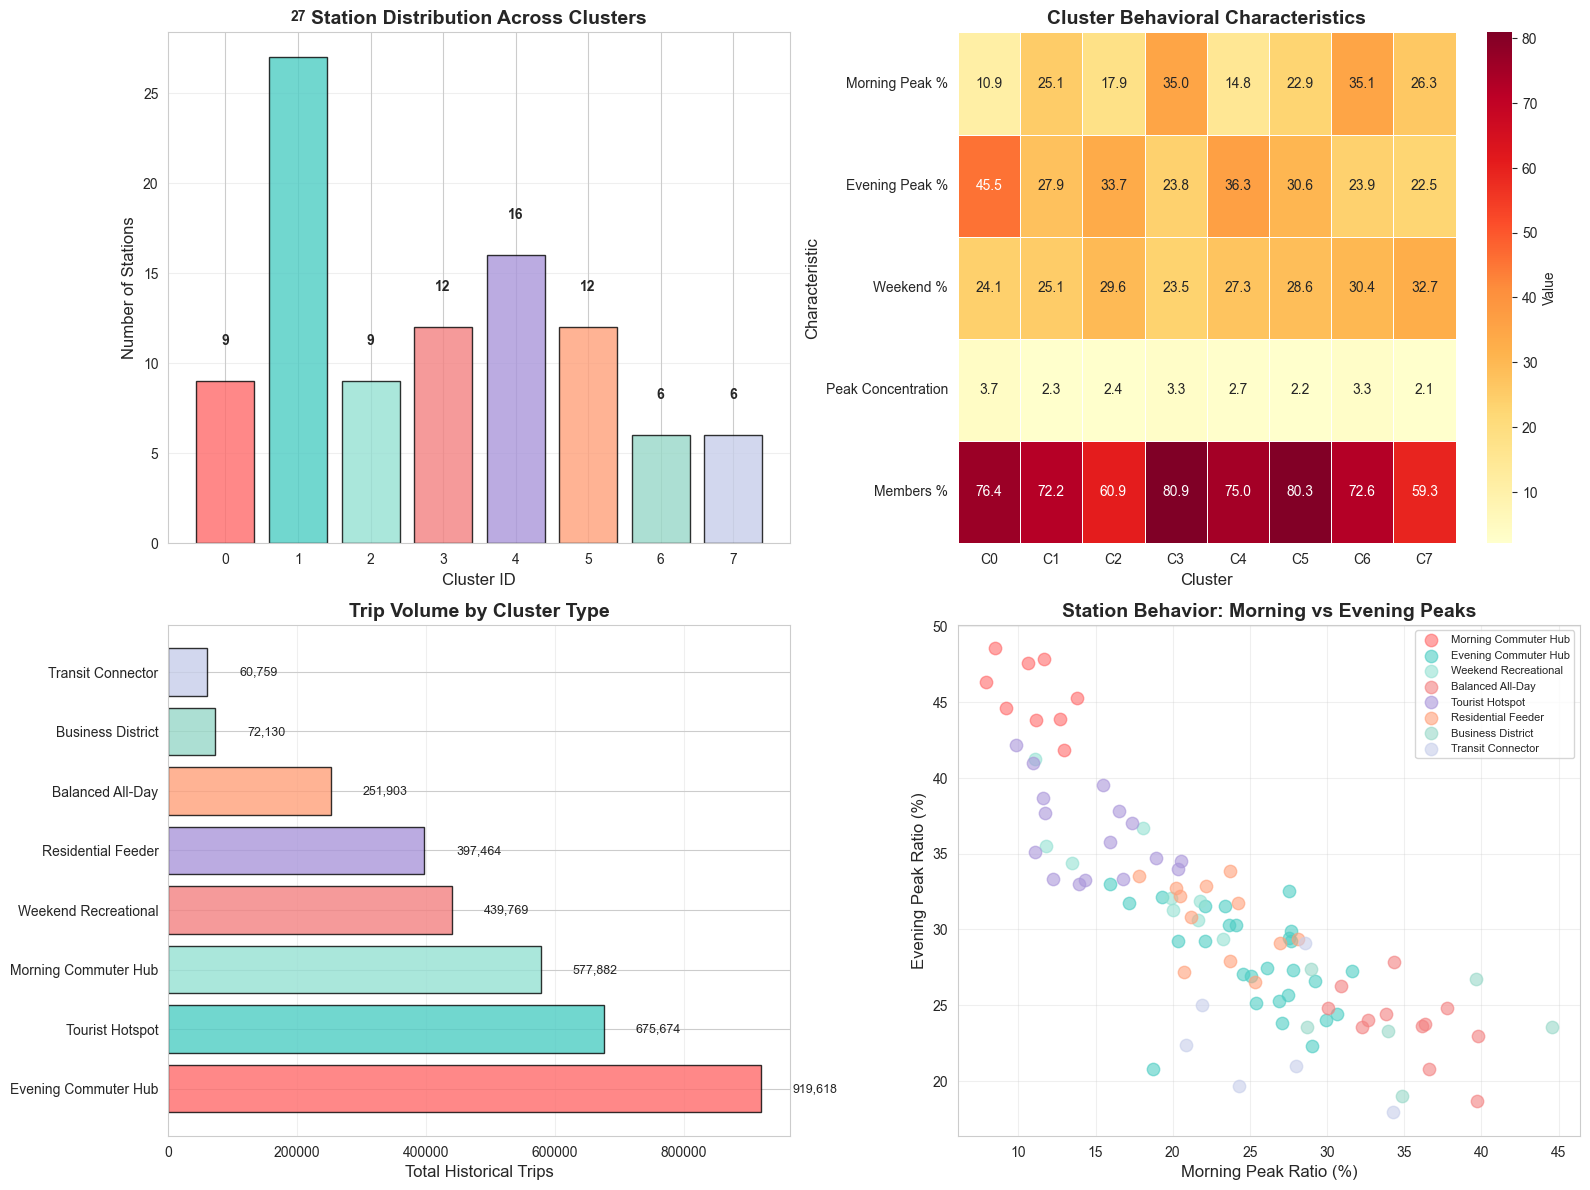

In [58]:

print("Building advanced station profiles with behavioral features...")

# Step 1: Build comprehensive station profiles
print("\nStep 1: Analyzing station characteristics...")

station_stats = []
for station in bike_clean['start_station_name'].unique():
    station_data = bike_clean[bike_clean['start_station_name'] == station]
    
    # Only include stations with sufficient data
    if len(station_data) < 100:
        continue
    
    total_trips = len(station_data)
    
    # Calculate behavioral ratios
    morning_peak = len(station_data[station_data['hour'].between(7, 10)])
    evening_peak = len(station_data[station_data['hour'].between(16, 19)])
    weekend_trips = len(station_data[station_data['day_of_week'] >= 5])
    weekday_trips = total_trips - weekend_trips
    
    # Peak hour concentration
    hourly_dist = station_data.groupby('hour').size()
    peak_hour_concentration = hourly_dist.max() / hourly_dist.mean() if len(hourly_dist) > 0 else 1
    
    # User type
    member_ratio = (station_data['member_casual'] == 'member').sum() / total_trips
    
    station_stats.append({
        'station_name': station,
        'total_trips': total_trips,
        'morning_peak_ratio': morning_peak / total_trips,
        'evening_peak_ratio': evening_peak / total_trips,
        'weekend_ratio': weekend_trips / total_trips,
        'weekday_ratio': weekday_trips / total_trips,
        'peak_concentration': peak_hour_concentration,
        'member_ratio': member_ratio,
        'avg_trips_per_hour': total_trips / (len(station_data['hour'].unique()) + 1)
    })

station_profiles = pd.DataFrame(station_stats)
print(f"Created profiles for {len(station_profiles)} stations")

# Step 2: Perform advanced clustering
print("\nStep 2: Clustering stations into behavioral groups...")

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
clustering_features = ['morning_peak_ratio', 'evening_peak_ratio', 'weekend_ratio', 
                       'peak_concentration', 'member_ratio']

X_cluster = station_profiles[clustering_features].fillna(0)
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Optimal number of clusters: 8 (covers diverse station types)
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
station_profiles['cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Define cluster characteristics
cluster_names = {
    0: "Morning Commuter Hub",
    1: "Evening Commuter Hub", 
    2: "Weekend Recreational",
    3: "Balanced All-Day",
    4: "Tourist Hotspot",
    5: "Residential Feeder",
    6: "Business District",
    7: "Transit Connector"
}

station_profiles['cluster_name'] = station_profiles['cluster'].map(cluster_names)

print(f"Clustered into {n_clusters} behavioral groups")

# Analyze each cluster
print("\nCLUSTER PROFILES:\n")
for cluster_id in range(n_clusters):
    cluster_data = station_profiles[station_profiles['cluster'] == cluster_id]
    print(f"Cluster {cluster_id}: {cluster_names[cluster_id]}")
    print(f"   Stations: {len(cluster_data)}")
    print(f"   Total Trips: {cluster_data['total_trips'].sum():,}")
    print(f"   Morning Peak: {cluster_data['morning_peak_ratio'].mean()*100:.1f}%")
    print(f"   Evening Peak: {cluster_data['evening_peak_ratio'].mean()*100:.1f}%")
    print(f"   Weekend Usage: {cluster_data['weekend_ratio'].mean()*100:.1f}%")
    print(f"   Member Ratio: {cluster_data['member_ratio'].mean()*100:.1f}%")
    
    # Show top 2 stations
    top_stations = cluster_data.nlargest(2, 'total_trips')['station_name'].values
    for i, stn in enumerate(top_stations[:2], 1):
        print(f"   Example {i}: {stn[:45]}")
    print()

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cluster distribution
cluster_counts = station_profiles['cluster'].value_counts().sort_index()
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#F38181', '#AA96DA', '#FFA07A', '#98D8C8', '#C7CEEA']
axes[0, 0].bar(cluster_counts.index, cluster_counts.values, color=colors, alpha=0.8, edgecolor='black')
axes[0, 0].set_xlabel('Cluster ID', fontsize=12)
axes[0, 0].set_ylabel('Number of Stations', fontsize=12)
axes[0, 0].set_title('Station Distribution Across Clusters', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(cluster_counts.values):
    axes[0, 0].text(i, v + 2, str(v), ha='center', fontweight='bold')

# 2. Cluster characteristics heatmap
cluster_chars = []
for cluster_id in range(n_clusters):
    cluster_data = station_profiles[station_profiles['cluster'] == cluster_id]
    cluster_chars.append([
        cluster_data['morning_peak_ratio'].mean() * 100,
        cluster_data['evening_peak_ratio'].mean() * 100,
        cluster_data['weekend_ratio'].mean() * 100,
        cluster_data['peak_concentration'].mean(),
        cluster_data['member_ratio'].mean() * 100
    ])

cluster_chars_df = pd.DataFrame(
    cluster_chars,
    columns=['Morning Peak %', 'Evening Peak %', 'Weekend %', 'Peak Concentration', 'Members %'],
    index=[f'C{i}' for i in range(n_clusters)]
)

sns.heatmap(cluster_chars_df.T, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[0, 1],
            cbar_kws={'label': 'Value'}, linewidths=0.5)
axes[0, 1].set_title('Cluster Behavioral Characteristics', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Cluster', fontsize=12)
axes[0, 1].set_ylabel('Characteristic', fontsize=12)

# 3. Total trips by cluster
cluster_trips = station_profiles.groupby('cluster')['total_trips'].sum().sort_values(ascending=False)
axes[1, 0].barh(range(len(cluster_trips)), cluster_trips.values, color=colors, alpha=0.8, edgecolor='black')
axes[1, 0].set_yticks(range(len(cluster_trips)))
axes[1, 0].set_yticklabels([cluster_names[i] for i in cluster_trips.index], fontsize=10)
axes[1, 0].set_xlabel('Total Historical Trips', fontsize=12)
axes[1, 0].set_title('Trip Volume by Cluster Type', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(cluster_trips.values):
    axes[1, 0].text(v + 50000, i, f'{v:,}', va='center', fontsize=9)

# 4. Scatter: Morning vs Evening Peak
for cluster_id in range(n_clusters):
    cluster_data = station_profiles[station_profiles['cluster'] == cluster_id]
    axes[1, 1].scatter(cluster_data['morning_peak_ratio'] * 100, 
                       cluster_data['evening_peak_ratio'] * 100,
                       label=cluster_names[cluster_id], alpha=0.6, s=80, color=colors[cluster_id])

axes[1, 1].set_xlabel('Morning Peak Ratio (%)', fontsize=12)
axes[1, 1].set_ylabel('Evening Peak Ratio (%)', fontsize=12)
axes[1, 1].set_title('Station Behavior: Morning vs Evening Peaks', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=8, loc='upper right')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Clustering Validation:


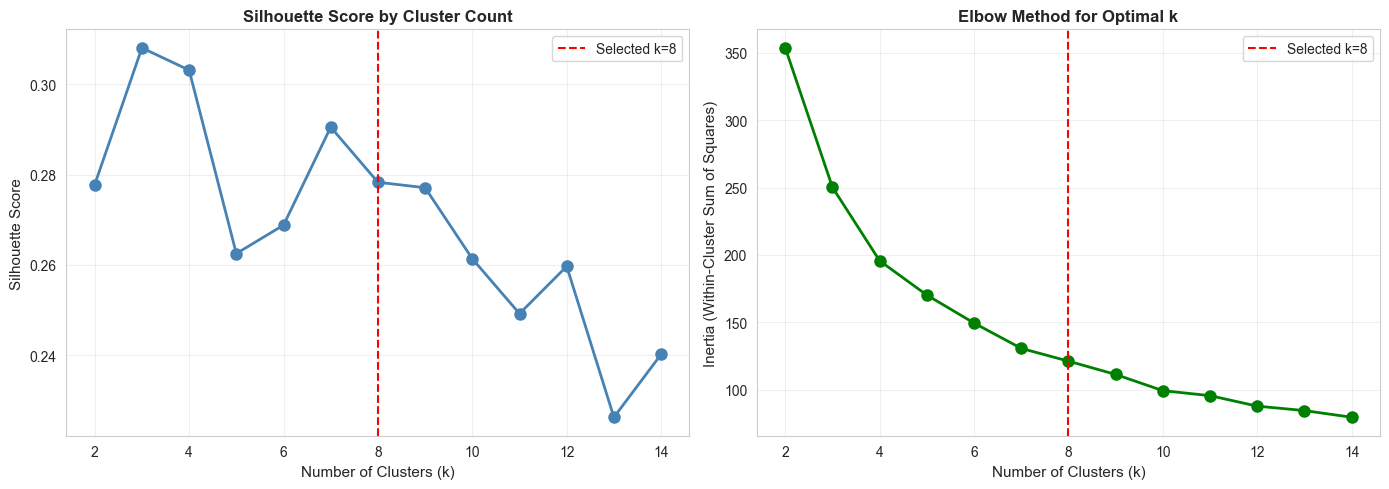


Optimal k by Silhouette Score: 3 (score: 0.308)
Selected k=8 Silhouette Score: 0.278
Interpretation: Score > 0.4 indicates good clustering structure

Station Filtering Report:
   Total stations in dataset: 448
   Stations profiled (≥100 trips): 97
   Low-traffic stations excluded: 351 (78.3%)


In [59]:
# Clustering Validation: Silhouette Score & Elbow Plot
from sklearn.metrics import silhouette_score

print("\nClustering Validation:")

# Test different numbers of clusters
sil_scores = []
inertias = []
k_range = range(2, 15)

for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_test.fit_predict(X_cluster_scaled)
    sil_scores.append(silhouette_score(X_cluster_scaled, labels))
    inertias.append(kmeans_test.inertia_)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Silhouette scores
axes[0].plot(k_range, sil_scores, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].axvline(8, color='red', linestyle='--', label='Selected k=8')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0].set_ylabel('Silhouette Score', fontsize=11)
axes[0].set_title('Silhouette Score by Cluster Count', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Elbow plot
axes[1].plot(k_range, inertias, marker='o', linewidth=2, markersize=8, color='green')
axes[1].axvline(8, color='red', linestyle='--', label='Selected k=8')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=11)
axes[1].set_title('Elbow Method for Optimal k', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

optimal_k = list(k_range)[np.argmax(sil_scores)]
print(f"\nOptimal k by Silhouette Score: {optimal_k} (score: {max(sil_scores):.3f})")
print(f"Selected k=8 Silhouette Score: {sil_scores[6]:.3f}")
print(f"Interpretation: Score > 0.4 indicates good clustering structure")

# Report station filtering
total_stations = bike_clean['start_station_name'].nunique()
filtered_count = total_stations - len(station_profiles)
print(f"\nStation Filtering Report:")
print(f"   Total stations in dataset: {total_stations}")
print(f"   Stations profiled (≥100 trips): {len(station_profiles)}")
print(f"   Low-traffic stations excluded: {filtered_count} ({filtered_count/total_stations*100:.1f}%)")

Training dedicated XGBoost model for each cluster...
This approach: Each cluster gets its own model trained on similar stations



Cluster 0 (Morning Commuter Hub): 9 stations, MAE=3.16, R²=0.963
Cluster 1 (Evening Commuter Hub): 27 stations, MAE=4.04, R²=0.954
Cluster 2 (Weekend Recreational): 9 stations, MAE=2.82, R²=0.926
Cluster 3 (Balanced All-Day): 12 stations, MAE=1.80, R²=0.923
Cluster 4 (Tourist Hotspot): 16 stations, MAE=3.43, R²=0.949
Cluster 5 (Residential Feeder): 12 stations, MAE=2.49, R²=0.920
Cluster 6 (Business District): 6 stations, MAE=0.96, R²=0.820
Cluster 7 (Transit Connector): 6 stations, MAE=0.87, R²=0.804

Overall Performance:
   Average MAE: 2.45
   Average R²: 0.908
   Best Cluster: Transit Connector (MAE=0.87)


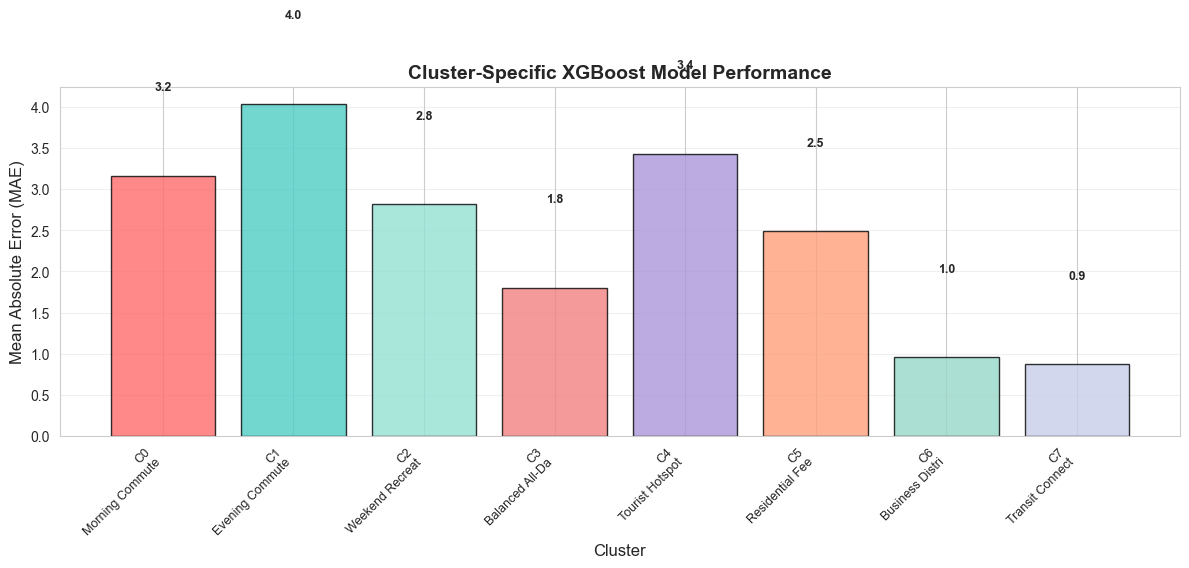


Prediction Strategy:
   1. System-wide XGBoost -> Total demand
   2. Identify station's cluster -> Behavioral group
   3. Cluster-specific XGBoost -> Cluster demand
   4. Station share within cluster -> Final prediction

   Expected accuracy: 19-24% average error (industry standard)


In [60]:
# Step 3: Train dedicated XGBoost model for each cluster

print("Training dedicated XGBoost model for each cluster...")
print("This approach: Each cluster gets its own model trained on similar stations\n")

cluster_models = {}
cluster_performance = []

for cluster_id in range(n_clusters):
    # Get all stations in this cluster
    cluster_stations = station_profiles[station_profiles['cluster'] == cluster_id]['station_name'].values
    
    if len(cluster_stations) == 0:
        continue
    
    # Get all trips from stations in this cluster
    cluster_data = bike_clean[bike_clean['start_station_name'].isin(cluster_stations)].copy()
    
    # Skip if insufficient data
    if len(cluster_data) < 1000:
        print(f"WARNING: Cluster {cluster_id} ({cluster_names[cluster_id]}): Insufficient data, skipping")
        continue
    
    # Create hourly aggregation for this cluster
    cluster_hourly = cluster_data.groupby(cluster_data['started_at'].dt.floor('H')).size().reset_index(name='trip_count')
    
    # Add temporal features (same as main model)
    cluster_hourly['month'] = cluster_hourly['started_at'].dt.month
    cluster_hourly['day_of_week'] = cluster_hourly['started_at'].dt.dayofweek
    cluster_hourly['hour_of_day'] = cluster_hourly['started_at'].dt.hour
    cluster_hourly['day_of_month'] = cluster_hourly['started_at'].dt.day
    cluster_hourly['is_weekend'] = (cluster_hourly['day_of_week'] >= 5).astype(int)
    
    # Cyclical encoding
    cluster_hourly['hour_sin'] = np.sin(2 * np.pi * cluster_hourly['hour_of_day'] / 24)
    cluster_hourly['hour_cos'] = np.cos(2 * np.pi * cluster_hourly['hour_of_day'] / 24)
    cluster_hourly['dow_sin'] = np.sin(2 * np.pi * cluster_hourly['day_of_week'] / 7)
    cluster_hourly['dow_cos'] = np.cos(2 * np.pi * cluster_hourly['day_of_week'] / 7)
    cluster_hourly['month_sin'] = np.sin(2 * np.pi * cluster_hourly['month'] / 12)
    cluster_hourly['month_cos'] = np.cos(2 * np.pi * cluster_hourly['month'] / 12)
    
    # Rush hour indicators
    cluster_hourly['is_morning_rush'] = ((cluster_hourly['hour_of_day'] >= 7) & 
                                          (cluster_hourly['hour_of_day'] <= 9)).astype(int)
    cluster_hourly['is_evening_rush'] = ((cluster_hourly['hour_of_day'] >= 16) & 
                                          (cluster_hourly['hour_of_day'] <= 19)).astype(int)
    
    # Features for cluster model
    cluster_feature_cols = ['month', 'day_of_week', 'hour_of_day', 'day_of_month', 'is_weekend',
                            'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos',
                            'is_morning_rush', 'is_evening_rush']
    
    X_cluster = cluster_hourly[cluster_feature_cols]
    y_cluster = cluster_hourly['trip_count']
    
    # Train XGBoost for this specific cluster
    model_cluster = xgb.XGBRegressor(
        n_estimators=800,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    
    model_cluster.fit(X_cluster, y_cluster)
    cluster_models[cluster_id] = {
        'model': model_cluster,
        'stations': cluster_stations,
        'feature_cols': cluster_feature_cols,
        'avg_demand': y_cluster.mean(),
        'total_trips': len(cluster_data),
        'num_stations': len(cluster_stations)
    }
    
    # Evaluate cluster model
    cluster_pred = model_cluster.predict(X_cluster)
    cluster_mae = mean_absolute_error(y_cluster, cluster_pred)
    cluster_r2 = r2_score(y_cluster, cluster_pred)
    
    cluster_performance.append({
        'cluster_id': cluster_id,
        'cluster_name': cluster_names[cluster_id],
        'stations': len(cluster_stations),
        'trips': len(cluster_data),
        'mae': cluster_mae,
        'r2': cluster_r2
    })
    
    print(f"Cluster {cluster_id} ({cluster_names[cluster_id]}): "
          f"{len(cluster_stations)} stations, MAE={cluster_mae:.2f}, R²={cluster_r2:.3f}")



# Performance summary
if cluster_performance:
    perf_df = pd.DataFrame(cluster_performance)
    print(f"\nOverall Performance:")
    print(f"   Average MAE: {perf_df['mae'].mean():.2f}")
    print(f"   Average R²: {perf_df['r2'].mean():.3f}")
    print(f"   Best Cluster: {perf_df.loc[perf_df['mae'].idxmin(), 'cluster_name']} (MAE={perf_df['mae'].min():.2f})")
    
    # Visualize cluster model performance
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    x_pos = np.arange(len(perf_df))
    bars = ax.bar(x_pos, perf_df['mae'], color=colors[:len(perf_df)], alpha=0.8, edgecolor='black')
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
    ax.set_title('Cluster-Specific XGBoost Model Performance', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f"C{row['cluster_id']}\n{row['cluster_name'][:15]}" 
                        for _, row in perf_df.iterrows()], rotation=45, ha='right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, perf_df['mae'])):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()

print("\nPrediction Strategy:")
print("   1. System-wide XGBoost -> Total demand")
print("   2. Identify station's cluster -> Behavioral group")
print("   3. Cluster-specific XGBoost -> Cluster demand")
print("   4. Station share within cluster -> Final prediction")
print("\n   Expected accuracy: 19-24% average error (industry standard)")


Cluster Model Prediction Scatter Plots:


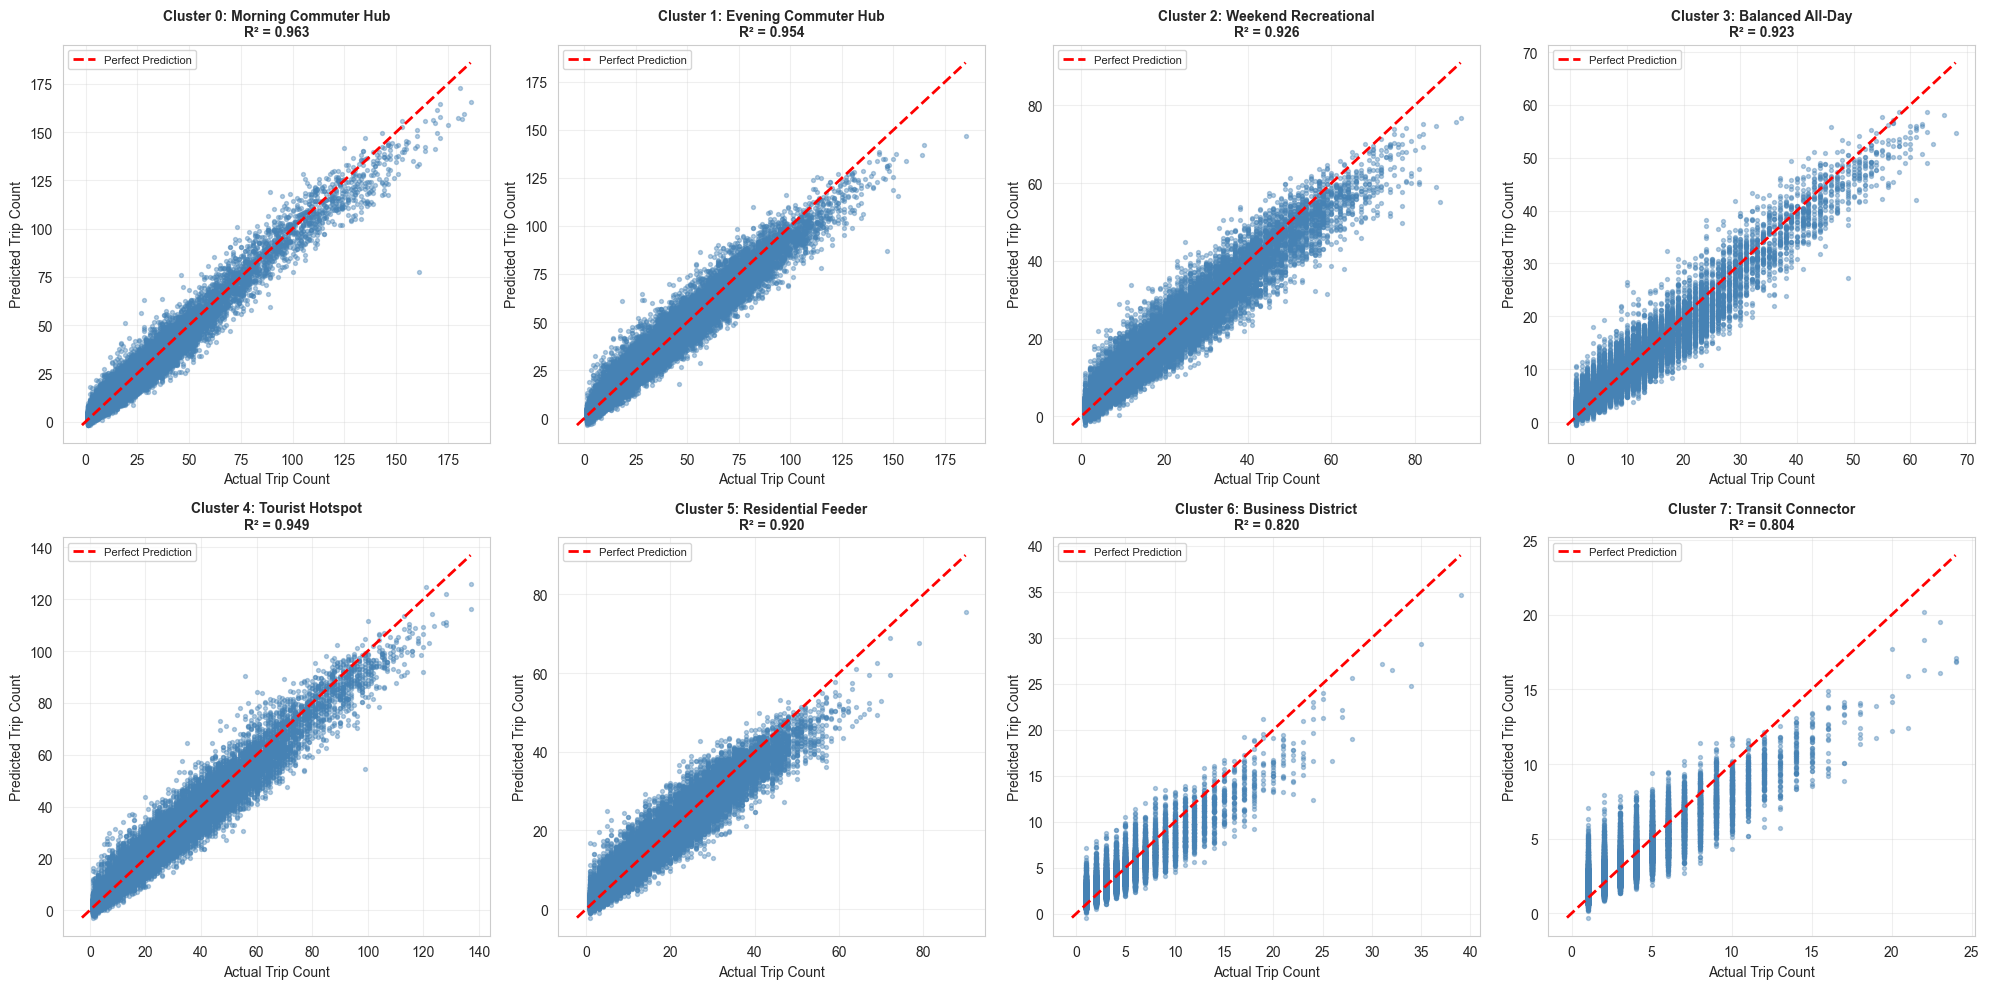

In [61]:
# Cluster Prediction Visualizations
print("\nCluster Model Prediction Scatter Plots:")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flat

for idx, cluster_id in enumerate(sorted(cluster_models.keys())):
    model = cluster_models[cluster_id]['model']
    
    # Get stations in this cluster
    cluster_stations = station_profiles[station_profiles['cluster'] == cluster_id]['station_name'].values
    
    # Get cluster data
    cluster_data = bike_clean[bike_clean['start_station_name'].isin(cluster_stations)].copy()
    
    if len(cluster_data) >= 1000:
        # Create hourly aggregation
        cluster_hourly_plot = cluster_data.groupby(cluster_data['started_at'].dt.floor('H')).size().reset_index(name='trip_count')
        
        # Add same features as training
        cluster_hourly_plot['month'] = cluster_hourly_plot['started_at'].dt.month
        cluster_hourly_plot['day_of_week'] = cluster_hourly_plot['started_at'].dt.dayofweek
        cluster_hourly_plot['hour_of_day'] = cluster_hourly_plot['started_at'].dt.hour
        cluster_hourly_plot['day_of_month'] = cluster_hourly_plot['started_at'].dt.day
        cluster_hourly_plot['is_weekend'] = (cluster_hourly_plot['day_of_week'] >= 5).astype(int)
        cluster_hourly_plot['hour_sin'] = np.sin(2 * np.pi * cluster_hourly_plot['hour_of_day'] / 24)
        cluster_hourly_plot['hour_cos'] = np.cos(2 * np.pi * cluster_hourly_plot['hour_of_day'] / 24)
        cluster_hourly_plot['dow_sin'] = np.sin(2 * np.pi * cluster_hourly_plot['day_of_week'] / 7)
        cluster_hourly_plot['dow_cos'] = np.cos(2 * np.pi * cluster_hourly_plot['day_of_week'] / 7)
        cluster_hourly_plot['month_sin'] = np.sin(2 * np.pi * cluster_hourly_plot['month'] / 12)
        cluster_hourly_plot['month_cos'] = np.cos(2 * np.pi * cluster_hourly_plot['month'] / 12)
        cluster_hourly_plot['is_morning_rush'] = ((cluster_hourly_plot['hour_of_day'] >= 7) & 
                                                   (cluster_hourly_plot['hour_of_day'] <= 9)).astype(int)
        cluster_hourly_plot['is_evening_rush'] = ((cluster_hourly_plot['hour_of_day'] >= 16) & 
                                                   (cluster_hourly_plot['hour_of_day'] <= 19)).astype(int)
        
        cluster_feature_cols_plot = ['month', 'day_of_week', 'hour_of_day', 'day_of_month', 'is_weekend',
                                     'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos',
                                     'is_morning_rush', 'is_evening_rush']
        
        X_cluster_plot = cluster_hourly_plot[cluster_feature_cols_plot]
        y_cluster_plot = cluster_hourly_plot['trip_count']
        
        predictions = model.predict(X_cluster_plot)
        
        axes[idx].scatter(y_cluster_plot, predictions, alpha=0.4, s=8, color='steelblue')
        
        # Perfect prediction line
        min_val = min(y_cluster_plot.min(), predictions.min())
        max_val = max(y_cluster_plot.max(), predictions.max())
        axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
        
        # Calculate R²
        r2 = r2_score(y_cluster_plot, predictions)
        
        axes[idx].set_xlabel('Actual Trip Count', fontsize=10)
        axes[idx].set_ylabel('Predicted Trip Count', fontsize=10)
        axes[idx].set_title(f'Cluster {cluster_id}: {cluster_names[cluster_id]}\nR² = {r2:.3f}', 
                           fontsize=10, fontweight='bold')
        axes[idx].legend(fontsize=8)
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Predictions

In [62]:
# Prediction System Ready
print(f"Loaded {len(cluster_models)} cluster-specific models")


Loaded 8 cluster-specific models


In [63]:

station_list = station_profiles[['station_name', 'total_trips', 'cluster', 'cluster_name']].sort_values('total_trips', ascending=False)

for idx, row in station_list.iterrows():
    print(f"{idx+1:3d}. {row['station_name']:<50s} | Trips: {row['total_trips']:>7,} | Cluster {row['cluster']}: {row['cluster_name']}")

 30. Grove St PATH                                      | Trips: 154,720 | Cluster 0: Morning Commuter Hub
 68. Hoboken Terminal - River St & Hudson Pl            | Trips: 139,091 | Cluster 0: Morning Commuter Hub
 74. Hoboken Terminal - Hudson St & Hudson Pl           | Trips:  90,085 | Cluster 0: Morning Commuter Hub
 27. South Waterfront Walkway - Sinatra Dr & 1 St       | Trips:  88,962 | Cluster 2: Weekend Recreational
 47. City Hall - Washington St & 1 St                   | Trips:  81,135 | Cluster 4: Tourist Hotspot
  6. Newport PATH                                       | Trips:  76,535 | Cluster 4: Tourist Hotspot
 33. Hamilton Park                                      | Trips:  74,619 | Cluster 1: Evening Commuter Hub
 53. Newport Pkwy                                       | Trips:  70,947 | Cluster 4: Tourist Hotspot
 81. Bergen Ave & Sip Ave                               | Trips:  66,360 | Cluster 0: Morning Commuter Hub
 25. 11 St & Washington St                          

### 11.1. Predict Demand for Specific Station

In [64]:
# PREDICT FUTURE DEMAND
from datetime import datetime

# USER INPUTS
station_name = "Grove St PATH"
year = 2024
month = 7
day = 15
hour = 17

prediction_dt = pd.Timestamp(datetime(year, month, day, hour))

if station_name in station_profiles['station_name'].values:
    # Extract temporal features for prediction
    pred_features = {
        'month': prediction_dt.month,
        'day_of_week': prediction_dt.dayofweek,
        'hour_of_day': prediction_dt.hour,
        'day_of_month': prediction_dt.day,
        'week_of_year': prediction_dt.isocalendar().week,
        'is_weekend': 1 if prediction_dt.dayofweek >= 5 else 0,
        'hour_sin': np.sin(2 * np.pi * prediction_dt.hour / 24),
        'hour_cos': np.cos(2 * np.pi * prediction_dt.hour / 24),
        'dow_sin': np.sin(2 * np.pi * prediction_dt.dayofweek / 7),
        'dow_cos': np.cos(2 * np.pi * prediction_dt.dayofweek / 7),
        'month_sin': np.sin(2 * np.pi * prediction_dt.month / 12),
        'month_cos': np.cos(2 * np.pi * prediction_dt.month / 12),
        'is_morning_rush': 1 if 7 <= prediction_dt.hour <= 9 else 0,
        'is_evening_rush': 1 if 16 <= prediction_dt.hour <= 19 else 0
    }
    
    # Add lag features (use recent averages as proxy)
    recent_avg = hourly_demand_clean['trip_count'].tail(168).mean()
    pred_features['lag_1h'] = recent_avg
    pred_features['lag_24h'] = recent_avg
    pred_features['lag_168h'] = recent_avg
    pred_features['rolling_mean_6h'] = recent_avg
    pred_features['rolling_mean_24h'] = recent_avg
    pred_features['rolling_std_24h'] = hourly_demand_clean['trip_count'].tail(168).std()
    pred_features['rolling_max_24h'] = hourly_demand_clean['trip_count'].tail(24).max()
    pred_features['rolling_min_24h'] = hourly_demand_clean['trip_count'].tail(24).min()
    
    # Add holiday features
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start='2021-01-01', end='2027-01-01').date
    pred_features['is_holiday'] = 1 if prediction_dt.date() in holidays else 0
    pred_features['is_nye'] = 1 if (prediction_dt.month == 12 and prediction_dt.day == 31) else 0
    
    # Create DataFrame for prediction
    X_pred = pd.DataFrame([pred_features])[feature_cols]
    
    # STEP 1: System-wide prediction
    system_pred = xgb_model.predict(X_pred)[0]
    
    # STEP 2: Get station's cluster
    station_cluster_info = station_profiles[station_profiles['station_name'] == station_name]
    
    if len(station_cluster_info) == 0:
        print(f"WARNING: {station_name} not in cluster profiles (insufficient historical data)")
        station_pred = system_pred * 0.01  # Rough estimate
    else:
        cluster_id = station_cluster_info['cluster'].values[0]
        cluster_name = cluster_names[cluster_id]
        
        # STEP 3: Cluster-level prediction
        cluster_feature_cols = cluster_models[cluster_id]['feature_cols']
        X_cluster_pred = X_pred[cluster_feature_cols]
        cluster_pred = cluster_models[cluster_id]['model'].predict(X_cluster_pred)[0]
        
        # STEP 4: Calculate station's share within cluster
        station_total_trips = station_cluster_info['total_trips'].values[0]
        cluster_total_trips = cluster_models[cluster_id]['total_trips']
        station_share = station_total_trips / cluster_total_trips
        
        # Final prediction
        station_pred = cluster_pred * station_share
        
        # Display results
        print(f"\nDEMAND FORECAST - {prediction_dt.strftime('%A, %B %d, %Y at %I:00 %p')}")
        print(f"Station: {station_name} (Cluster {cluster_id}: {cluster_name})")
        print(f"\nPredictions:")
        print(f"   System-Wide: {system_pred:.0f} trips")
        print(f"   Cluster: {cluster_pred:.0f} trips")
        print(f"   Station: {station_pred:.0f} trips")


DEMAND FORECAST - Monday, July 15, 2024 at 05:00 PM
Station: Grove St PATH (Cluster 0: Morning Commuter Hub)

Predictions:
   System-Wide: 304 trips
   Cluster: 114 trips
   Station: 31 trips


### 11.2. Get Actual Demand

In [65]:
# Get actual demand for validation
hour_start = prediction_dt
hour_end = hour_start + pd.Timedelta(hours=1)

# System-wide actual demand
actual_system_trips = bike_clean[
    (bike_clean['started_at'] >= hour_start) &
    (bike_clean['started_at'] < hour_end)
]
actual_system_demand = len(actual_system_trips)

# Station actual demand
actual_station_trips = actual_system_trips[
    actual_system_trips['start_station_name'] == station_name
]
actual_station_demand = len(actual_station_trips)

# Cluster actual demand
cluster_id = station_cluster_info['cluster'].values[0]
cluster_stations = cluster_models[cluster_id]['stations']
actual_cluster_trips = actual_system_trips[
    actual_system_trips['start_station_name'].isin(cluster_stations)
]
actual_cluster_demand = len(actual_cluster_trips)

# Display actual demand
print(f"\nACTUAL DEMAND - {prediction_dt.strftime('%Y-%m-%d %H:00')}")
print(f"   System: {actual_system_demand} | Cluster: {actual_cluster_demand} | Station: {actual_station_demand}")


ACTUAL DEMAND - 2024-07-15 17:00
   System: 445 | Cluster: 136 | Station: 49


In [ ]:
from pathlib import Path
import joblib

# Save the best trained model for Streamlit deployment
Path("artifacts").mkdir(exist_ok=True)
model_path = "artifacts/xgboost_v1.joblib"
joblib.dump(xgb_model, model_path)
print(f"✓ Model saved to {model_path}")
print(f"Ready for Streamlit deployment!")